# Загрузка

In [10]:
target = df_hardness.columns[-3:]

In [1]:
ls_columns_output = [
#     '№ партии',
#     '№ плавки',
    'марка стали',
    'диаметр',
    'толщина стенки',
    'Гр. прочн.',
    '1 зона по ВТР закалка',
    '2 зона по ВТР закалка',
    '3 зона по ВТР закалка',
    'шаг балок закалочная печь, сек',
    'Скорость прохождения трубы через спрейер, м/с', 
    't˚ C трубы после спреера',
    '1 зона ВТР и уставка отпуск', 
    '2 зона ВТР и уставка отпуск', 
    '3 зона ВТР и уставка отпуск',
    '4 зона ВТР и уставка отпуск',
    '5 зона ВТР и уставка отпуск',
    'шаг балок отпускная печь, сек',
    'C',
    'Mn',
    'Si',
    'P',
    'S',
    'Cr',
    'Ni',
    'Cu',
    'Al',
    'V',
    'Ti',
    'Nb',
    'Mo',
    'N',
    'B',
    'C-coef',
    'Параметр закалка',
    'Параметр отпуск',
    'Параметр отпуск новый V',
    'Величина зерна',
    'Тип предела текучести (1186)',
#     'Дата термообработки',
    'ICD',
#     'Примечание',
    'длина трубы'
    ]

In [2]:
import pandas as pd
import numpy as np
import import_ipynb
from my_libs.calc_features import *
import random
from datetime import datetime

importing Jupyter notebook from C:\Users\kseniya.yuldasheva\Desktop\gitPNTZtoyuk_1\gitPNTZ\PNTZ\my_libs\calc_features.ipynb


In [3]:
pd.options.display.max_columns = 500
pd.options.display.max_rows = 1000

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, matthews_corrcoef, median_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, ExtraTreesRegressor
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_predict, cross_validate, train_test_split, GridSearchCV
from sklearn import model_selection
import matplotlib.pyplot as plt
import os
from time import time
from datetime import datetime
from my_libs.save_lib import save_RF_model
from scipy.stats.stats import pearsonr

importing Jupyter notebook from C:\Users\kseniya.yuldasheva\Desktop\gitPNTZtoyuk_1\gitPNTZ\PNTZ\my_libs\save_lib.ipynb


C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [21]:
df = pd.read_csv('DATA/prepared/prepared_to_saw_gp.csv', low_memory=False)

In [23]:
df_hardness = pd.read_excel('DATA/source/exp/prepared/table_hardness_api.xlsx')

In [24]:
df_hardness.columns[-3:]

Index(['Число твердости на середине поверхности (1148)',
       'Число твердости на внутренней поверхности (1149)',
       'Число твердости у наружной поверхности (1147)'],
      dtype='object')

In [25]:
['№ плавки', '№ партии'] + list(df_hardness.columns[-3:])

['№ плавки',
 '№ партии',
 'Число твердости на середине поверхности (1148)',
 'Число твердости на внутренней поверхности (1149)',
 'Число твердости у наружной поверхности (1147)']

In [26]:
df_hardness = df_hardness[['№ плавки', '№ партии'] + list(df_hardness.columns[-3:])]

In [27]:
df_hardness.shape

(6802, 5)

In [28]:
df_hardness = df_hardness.groupby(['№ плавки', '№ партии'])[list(df_hardness.columns[-3:])].mean()

In [29]:
df_hardness = pd.DataFrame(df_hardness)

In [30]:
df_hardness.reset_index(inplace=True)

In [31]:
df_hardness.shape

(3156, 5)

In [32]:
df_hardness['№ плавки'] = df_hardness['№ плавки'].astype(str)
df_hardness['№ плавки'] = df_hardness['№ плавки'].apply(lambda x: x.lower())
df_hardness['№ партии'] = df_hardness['№ партии'].astype(str)
df['№ плавки'] = df['№ плавки'].astype(str)
df['№ плавки'] = df['№ плавки'].apply(lambda x: x.lower())
df['№ партии'] = df['№ партии'].astype(str)

In [36]:
df_ = pd.merge(df, df_hardness, on=['№ плавки', '№ партии'], how='left')
df_.shape

(24503, 204)

In [37]:
def bath2spr(df):
    L = 8.4
    df['Скорость прохождения трубы через спрейер, м/с'] = L/df['время выдержки в закалочной ванне, сек.']
    df['t˚ C трубы после спреера'] = df['t˚ C трубы после ванны']
    return df

In [38]:
bath = df_[~df_['время выдержки в закалочной ванне, сек.'].isnull()].copy()
df_ = df_[df_['время выдержки в закалочной ванне, сек.'].isnull()].copy()


bath = bath2spr(bath)

df = pd.concat([df_, bath])
df.reset_index(inplace=True, drop=True)

In [39]:
df.shape

(24503, 204)

In [40]:
df = len_pipe(df)

df = mean_chem(df)

df = calc_all_features(df)

C:\Users\kseniya.yuldasheva\Desktop\gitPNTZtoyuk_1\gitPNTZ\PNTZ\my_libs\calc_features.ipynb:127: RuntimeWarning: divide by zero encountered in log10
  "\n",


In [41]:
df = df[df['шаг балок закалочная печь, сек'] < 100]
df = df[df['шаг балок закалочная печь, сек'] >= 24]
df = df[df['шаг балок отпускная печь, сек'] >= 24]
df = df[df['Скорость прохождения трубы через спрейер, м/с'] <= 1]
df = df[df['t˚ C трубы после спреера'] > 1]
df = df[df['t˚ C трубы после спреера'] <= 250]
df = df[df['2 зона ВТР и уставка отпуск'] > 400]
df = df[df['4 зона ВТР и уставка отпуск'] > 400]

In [42]:
df_.shape

(23403, 204)

In [43]:
df_['Дата термообработки'] = df_['Дата термообработки'].apply(lambda x: str(x).replace(' 00:00:00', ''))
df_['Дата термообработки'] = df_['Дата термообработки'].apply(lambda x: str(x).replace('-', '.'))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000029480EC56D8>,
      dtype=object)

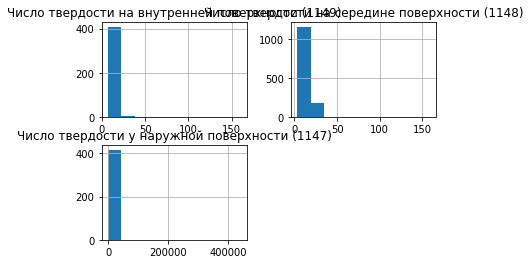

In [44]:
df_[target].hist()

In [106]:
df_[target].describe()

,Число твердости на середине поверхности (1148),Число твердости на внутренней поверхности (1149),Число твердости у наружной поверхности (1147)
count,401.000000,401.000000,401.000000
mean,18.136232,17.558687,22.403076
std,7.471136,7.605900,66.116551
min,8.000000,7.500000,6.500000
25%,16.150000,16.000000,15.500000
50%,18.000000,17.500000,17.500000
75%,19.500000,18.800000,19.500000
max,158.700000,160.100000,1265.000000


In [45]:
tmp = []
for x in df_['Дата термообработки']:
    try:
        tmp.append(datetime.strptime(x, "%d.%m.%Y"))
    except ValueError:
        tmp.append(datetime.strptime(x, "%Y.%m.%d"))
df_['Дата термообработки'] = tmp

In [48]:
df[ls_columns_output+list(target)].dropna().shape

(400, 42)

In [73]:
ls_train = ls_columns_output.copy()
# ls_train.remove('Дата термообработки')
ls_train.remove('марка стали')
ls_train.remove('Гр. прочн.')

# for s in ls_to_del:
#     ls_train.remove(s)

In [74]:
df_ = df[ls_train+list(target)].dropna()

X, X_valid, y, y_valid = train_test_split(df_[ls_train], df_[target], test_size=0.2)

In [75]:
X.shape, X_valid.shape

((320, 37), (81, 37))

In [76]:
X.columns

Index(['диаметр', 'толщина стенки', '1 зона по ВТР закалка',
       '2 зона по ВТР закалка', '3 зона по ВТР закалка',
       'шаг балок закалочная печь, сек',
       'Скорость прохождения трубы через спрейер, м/с',
       't˚ C трубы после спреера', '1 зона ВТР и уставка отпуск',
       '2 зона ВТР и уставка отпуск', '3 зона ВТР и уставка отпуск',
       '4 зона ВТР и уставка отпуск', '5 зона ВТР и уставка отпуск',
       'шаг балок отпускная печь, сек', 'C', 'Mn', 'Si', 'P', 'S', 'Cr', 'Ni',
       'Cu', 'Al', 'V', 'Ti', 'Nb', 'Mo', 'N', 'B', 'C-coef',
       'Параметр закалка', 'Параметр отпуск', 'Параметр отпуск новый V',
       'Величина зерна', 'Тип предела текучести (1186)', 'ICD', 'длина трубы'],
      dtype='object')

In [102]:
def print_and_return_score(x, y, est, verb=1):
    y_pred = est.predict(x)
#     scr = est.score(x, y)
    mae = mean_absolute_error(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    corr = []
    for i in range(y.columns.size):
        corr.append(np.corrcoef(y.iloc[:, i].T, 
                                y_pred[:, i]))
    
    if verb==1:        
        print('Score: ', round(scr, 2))
        print('R^2: ', round(r2, 2))
        print('MAE: ', round(mae, 2))
        print('MSE: ', round(mse, 2))
        print('Correlation1: ', round(corr[0][0][1], 2))
        print('Correlation2: ', round(corr[1][0][1], 2))
        print('Correlation3: ', round(corr[2][0][1], 2))
    return [scr, mae, mse, corr[0][0][1], corr[1][0][1], corr[2][0][1]]

In [103]:
X_train, X_test,  y_train, y_test = train_test_split(X, y, test_size=0.2)

In [104]:
len(ls_train)

37

In [105]:
rfc = RandomForestRegressor(max_features = 13, max_depth = 18, min_samples_leaf = 1, n_estimators=50, criterion='mse')
rfc.fit(X_train, y_train)

scr, mae, mse, corr1, corr2, corr3 = print_and_return_score(X_test, y_test, rfc)

Score:  -0.02
R^2:  -11.55
MAE:  9.25
MSE:  4348.47
Correlation1:  -0.08
Correlation2:  -0.0
Correlation3:  -0.01


In [80]:
val = rfc.feature_importances_
lab = ls_train
dict_feat_import = dict(zip(lab, val))
ls_to_del = []
for feat, imp in zip(lab, val):
    print(feat, '  ', imp.round(2))
    if imp.round(2) < 0.01:
        ls_to_del.append(feat)

диаметр    0.01
толщина стенки    0.0
1 зона по ВТР закалка    0.0
2 зона по ВТР закалка    0.0
3 зона по ВТР закалка    0.0
шаг балок закалочная печь, сек    0.0
Скорость прохождения трубы через спрейер, м/с    0.0
t˚ C трубы после спреера    0.02
1 зона ВТР и уставка отпуск    0.03
2 зона ВТР и уставка отпуск    0.0
3 зона ВТР и уставка отпуск    0.05
4 зона ВТР и уставка отпуск    0.01
5 зона ВТР и уставка отпуск    0.02
шаг балок отпускная печь, сек    0.01
C    0.01
Mn    0.05
Si    0.02
P    0.01
S    0.03
Cr    0.04
Ni    0.2
Cu    0.03
Al    0.0
V    0.13
Ti    0.02
Nb    0.0
Mo    0.03
N    0.0
B    0.0
C-coef    0.02
Параметр закалка    0.01
Параметр отпуск    0.05
Параметр отпуск новый V    0.07
Величина зерна    0.02
Тип предела текучести (1186)    0.0
ICD    0.08
длина трубы    0.02


In [81]:
ls_to_del

['толщина стенки',
 '1 зона по ВТР закалка',
 '2 зона по ВТР закалка',
 '3 зона по ВТР закалка',
 'шаг балок закалочная печь, сек',
 'Скорость прохождения трубы через спрейер, м/с',
 '2 зона ВТР и уставка отпуск',
 'Al',
 'Nb',
 'N',
 'B',
 'Тип предела текучести (1186)']

In [83]:
lr = LinearRegression()
lr.fit(X_train, y_train)

scr, mae, mse = print_and_return_score(X_test, y_test, lr)

R^2:  -651.55
MAE:  16.42
MSE:  3711.45


In [85]:

from sklearn.linear_model import RidgeCV, Lasso, LassoLars, BayesianRidge,SGDRegressor, Perceptron, HuberRegressor

l = HuberRegressor()
l.fit(X_train, y_train)

scr, mae, mse = print_and_return_score(X_test, y_test, l)

ValueError: bad input shape (256, 3)

In [87]:
c = 1
r = RidgeCV(alphas=[0.1, 1.0, 10.0])
r.fit(X_train, y_train)

scr, mae, mse= print_and_return_score(X_test, y_test, lr)
r.alpha_

R^2:  -651.55
MAE:  16.42
MSE:  3711.45


10.0

In [89]:
from sklearn.ensemble import GradientBoostingRegressor

g = GradientBoostingRegressor()
g.fit(X_train, y_train)

scr, mae, mse = print_and_return_score(X_test, y_test, g)

ValueError: bad input shape (256, 3)

In [90]:
# import tensorflow as tf
import theano
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers.normalization import BatchNormalization

Can not use cuDNN on context None: cannot compile with cuDNN. We got this error:
b'c:\\Temp\\try_flags_lsco4z49.c:4:19: fatal error: cudnn.h: No such file or directory\r\ncompilation terminated.\r\n'
Mapped name None to device cuda: GeForce GTX 1060 6GB (0000:01:00.0)


In [91]:
model = Sequential()
model.add(Dense(units=4,input_dim=X_train.shape[1]))
model.add(Activation('tanh'))
model.add(Dense(units=3))
model.compile(
        loss=keras.losses.logcosh,
        # loss=keras.losses.mean_absolute_error,
        metrics=[keras.metrics.mean_absolute_error],
#             optimizer=keras.optimizers.SGD(lr=0.05, momentum=0.6, decay=1e-7, nesterov=True)
            optimizer=keras.optimizers.Adam(lr=0.01, beta_1=0.85, beta_2=0.98, epsilon=1e-7, decay=1e-7, amsgrad=True)
#         optimizer=keras.optimizers.RMSprop(lr=0.01, rho=0.8, epsilon=None, decay=0.0)
#     optimizer=keras.optimizers.SGD(lr=0.001, momentum = 0.8, decay=1e-6)
#     optimizer = keras.optimizers.Nadam(lr=0.003, beta_1=0.99, beta_2=0.999, epsilon=None, schedule_decay=0.005)
        )

model.fit(X_train, y_train, batch_size = 16, epochs=100, shuffle=True)

Epoch 1/100
256/256 [==============================] - 2s 8ms/step - loss: 18.8462 - mean_absolute_error: 19.5393
Epoch 2/100
256/256 [==============================] - 0s 200us/step - loss: 18.0415 - mean_absolute_error: 18.7346
Epoch 3/100
256/256 [==============================] - 0s 196us/step - loss: 17.2333 - mean_absolute_error: 17.9265
Epoch 4/100
256/256 [==============================] - 0s 196us/step - loss: 16.4284 - mean_absolute_error: 17.1215
Epoch 5/100
256/256 [==============================] - 0s 188us/step - loss: 15.6253 - mean_absolute_error: 16.3185
Epoch 6/100
256/256 [==============================] - 0s 188us/step - loss: 14.8234 - mean_absolute_error: 15.5165
Epoch 7/100
256/256 [==============================] - 0s 192us/step - loss: 14.0225 - mean_absolute_error: 14.7152
Epoch 8/100
256/256 [==============================] - 0s 192us/step - loss: 13.2232 - mean_absolute_error: 13.9150
Epoch 9/100
256/256 [==============================] - 0s 192us/step - los

256/256 [==============================] - 0s 172us/step - loss: 4.3846 - mean_absolute_error: 4.9452
Epoch 73/100
256/256 [==============================] - 0s 161us/step - loss: 4.3845 - mean_absolute_error: 4.9451
Epoch 74/100
256/256 [==============================] - 0s 137us/step - loss: 4.3852 - mean_absolute_error: 4.9453
Epoch 75/100
256/256 [==============================] - 0s 141us/step - loss: 4.3846 - mean_absolute_error: 4.9450
Epoch 76/100
256/256 [==============================] - 0s 137us/step - loss: 4.3847 - mean_absolute_error: 4.9451
Epoch 77/100
256/256 [==============================] - 0s 133us/step - loss: 4.3849 - mean_absolute_error: 4.9458
Epoch 78/100
256/256 [==============================] - 0s 133us/step - loss: 4.3845 - mean_absolute_error: 4.9454
Epoch 79/100
256/256 [==============================] - 0s 137us/step - loss: 4.3848 - mean_absolute_error: 4.9455
Epoch 80/100
256/256 [==============================] - 0s 145us/step - loss: 4.3849 - mean_a

In [92]:
scr, mae, mse = print_and_return_score(X_test, y_test, model)

R^2:  -0.02
MAE:  1.9
MSE:  5.86
